In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Sopprimi i RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Lettura dati

In [3]:
dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati = dati[['Date', 'Close']]
dati = dati.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d')
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d')
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3503,2024-04-20,59876.710938
3504,2024-04-21,60956.074219
3505,2024-04-22,60919.242188
3506,2024-04-23,62729.296875


In [4]:
data_inizio = '2014-09-17'
data_fine = '2024-04-24'
indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3503,2024-04-20,59876.710938
3504,2024-04-21,60956.074219
3505,2024-04-22,60919.242188
3506,2024-04-23,62729.296875


In [5]:
def calcola_rendimento_portafoglio_ideale(lista_prezzi, capitale_iniziale, bitcoin_iniziali, min_acquisto=0, min_vendita=0, perc_commissione_acquisto=0, perc_commissione_vendita=0):
    capitale = capitale_iniziale
    bitcoin = bitcoin_iniziali
    comprato = False

    for i in range(len(lista_prezzi) - 1):
        # Compra al minimo
        if lista_prezzi[i] < lista_prezzi[i + 1] and not comprato and capitale >= min_acquisto:
            bitcoin_acquistati = (capitale * (1 - perc_commissione_acquisto)) / lista_prezzi[i]
            bitcoin += bitcoin_acquistati
            capitale = 0
            comprato = True
            # print(f'Bitcoin posseduti: {bitcoin}')
        # Vende al massimo
        elif lista_prezzi[i] > lista_prezzi[i + 1] and comprato and bitcoin * lista_prezzi[i] >= min_vendita:
            capitale_vendita = bitcoin * lista_prezzi[i] * (1 - perc_commissione_vendita)
            capitale += capitale_vendita
            bitcoin = 0
            comprato = False
            # print(f'Capitale posseduto: {capitale}')

    # Vende i bitcoin rimasti all'ultimo prezzo
    if comprato and bitcoin * lista_prezzi.iloc[-1] >= min_vendita:
        capitale += bitcoin * lista_prezzi.iloc[-1] * (1 - perc_commissione_vendita)
        bitcoin = 0
        # print(f'Capitale posseduto: {capitale}')
        # print(f'Bitcoin posseduti: {bitcoin}')

    valore_iniziale = capitale_iniziale + bitcoin_iniziali * lista_prezzi[0]
    valore_finale = capitale + bitcoin * lista_prezzi.iloc[-1]

    rendimento = valore_finale / valore_iniziale

    return [rendimento, valore_finale]

In [6]:
def estrai_periodi_casuali(dati, N, L, start_date, end_date, random_state):
    # Filtra i dati tra start_date e end_date
    dati_filtrati = dati[(dati['Timestamp'] >= pd.to_datetime(start_date)) & 
                         (dati['Timestamp'] <= pd.to_datetime(end_date))]
    
    # Calcola il numero massimo di periodi non sovrapposti
    num_max_periodi = len(dati_filtrati) - L + 1
    
    # Controlla se è possibile estrarre N periodi diversi
    if num_max_periodi < N:
        raise ValueError(f"Non è possibile estrarre {N} periodi diversi di lunghezza {L} tra le date {start_date} e {end_date}. Possono essere al massimo {num_max_periodi}.")
    
    # Inizializza una lista per i periodi estratti e un set per memorizzare gli estremi
    periodi_estratti = []
    estremi_estratti = set()
    
    # Inizializza il generatore di numeri casuali con il seed dato
    rng = np.random.RandomState(random_state)
    
    while len(periodi_estratti) < N:
        # Seleziona un indice casuale per l'inizio del periodo
        indice_inizio = rng.randint(0, len(dati_filtrati) - L + 1)
        
        # Determina gli estremi del periodo
        estremo_inizio = dati_filtrati.iloc[indice_inizio]['Timestamp']
        estremo_fine = dati_filtrati.iloc[indice_inizio + L - 1]['Timestamp']
        
        # Controlla se gli estremi sono già stati utilizzati
        if (estremo_inizio, estremo_fine) not in estremi_estratti:
            # Aggiungi gli estremi al set
            estremi_estratti.add((estremo_inizio, estremo_fine))
            
            # Estrai il periodo e aggiungilo alla lista dei periodi estratti
            periodo = dati_filtrati.iloc[indice_inizio:indice_inizio + L]

            periodo = periodo.reset_index(drop=True)

            periodi_estratti.append(periodo)
    
    return periodi_estratti

In [7]:
# Esempio di utilizzo:
start_date = dati['Timestamp'].iloc[0]
end_date = dati['Timestamp'].iloc[-1]
N = 3000 # Numero di periodi da estrarre
L = 60 # Lunghezza di ogni periodo in giorni
random_state = 8

In [8]:
periodi_casuali_esistenti = estrai_periodi_casuali(dati, N, L, start_date, end_date, random_state)
print('Fattore di ritorno medio dei prezzi estratti:', np.mean([df['Price'].iloc[-1] / df['Price'].iloc[0] for df in periodi_casuali_esistenti]))

ideal_returns = [calcola_rendimento_portafoglio_ideale(df['Price'], 1000, 0, 5, 5, 0.001, 0.001)[0] for df in periodi_casuali_esistenti]

print('Media dei fattori di rendimento massimi ottenibili:', np.mean(ideal_returns))

perc_suff = np.mean([1/calcola_rendimento_portafoglio_ideale(df['Price'], 1000, 0, 5, 5, 0.001, 0.001)[0] for df in periodi_casuali_esistenti])

print(f'Punteggio percentuale considerato "sufficiente": {round(perc_suff*100,2)}%')

Fattore di ritorno medio dei prezzi estratti: 1.1500421594461692
Media dei fattori di rendimento massimi ottenibili: 2.2005397172421484
Punteggio percentuale considerato "sufficiente": 51.01%


In [10]:
dati_da_usare = periodi_casuali_esistenti.copy()

## Estrazione dataset reali

In [11]:
def calcola_punteggio_bullish(dataset):
    variazioni = np.diff(dataset['Price'])
    salite = np.sum(variazioni[variazioni > 0])
    discese = np.sum(np.abs(variazioni[variazioni < 0]))
    punteggio = 2 * (salite / (salite + discese)) - 1
    return punteggio

punteggi_normalizzati = [calcola_punteggio_bullish(df) for df in dati_da_usare]

In [12]:
punteggi_normalizzati[:10]

[np.float64(-0.126712774985569),
 np.float64(-0.020462544807182237),
 np.float64(0.20349283878871316),
 np.float64(-0.1561117865673638),
 np.float64(0.42666530557213167),
 np.float64(0.08906025558049446),
 np.float64(0.40645977837425407),
 np.float64(-0.09823852535198097),
 np.float64(0.03823084154498968),
 np.float64(0.18878346211682095)]

In [13]:
# Dividi i punteggi normalizzati in n_clusters intervalli
n_clusters = 7
intervallo = np.linspace(-1, 1, n_clusters + 1)
clusters = np.digitize(punteggi_normalizzati, intervallo)

# Calcola le statistiche per ogni cluster
statistiche = []
for i in range(n_clusters):
    # Utilizza una lista di booleani per selezionare i dataset appartenenti al cluster i
    cluster_i = [df for df, cluster in zip(dati_da_usare, clusters) if cluster == i]
    punteggi_cluster_i = [punteggio for punteggio, cluster in zip(punteggi_normalizzati, clusters) if cluster == i]

    statistiche.append({
        'Cluster': i+1,
        'Intervallo': intervallo[i:i+2],
        'Numero di dataset': len(cluster_i),
        'Media del punteggio': np.mean(punteggi_cluster_i) if punteggi_cluster_i else 0,
        'Mediana del punteggio': np.median(punteggi_cluster_i) if punteggi_cluster_i else 0,
        'Deviazione standard del punteggio': np.std(punteggi_cluster_i) if punteggi_cluster_i else 0,
        'Minimo del punteggio': np.min(punteggi_cluster_i) if punteggi_cluster_i else 0,
        'Massimo del punteggio': np.max(punteggi_cluster_i) if punteggi_cluster_i else 0
    })

# Visualizza le statistiche
df_statistiche = pd.DataFrame(statistiche)
df_statistiche

,Cluster,Intervallo,Numero di dataset,Media del punteggio,Mediana del punteggio,Deviazione standard del punteggio,Minimo del punteggio,Massimo del punteggio
0,1,"[-1.0, -0.7142857142857143]",0,0.000000,0.000000,0.000000,0.000000,0.000000
1,2,"[-0.7142857142857143, -0.4285714285714286]",0,0.000000,0.000000,0.000000,0.000000,0.000000
2,3,"[-0.4285714285714286, -0.1428571428571429]",9,-0.476993,-0.485191,0.023696,-0.516513,-0.443653
3,4,"[-0.1428571428571429, 0.1428571428571428]",544,-0.223674,-0.212272,0.060414,-0.422608,-0.143197
4,5,"[0.1428571428571428, 0.4285714285714284]",1316,0.003172,0.003321,0.083468,-0.142730,0.142637
5,6,"[0.4285714285714284, 0.7142857142857142]",989,0.259807,0.245151,0.082126,0.142903,0.428195
6,7,"[0.7142857142857142, 1.0]",142,0.490154,0.473648,0.052693,0.429715,0.642298


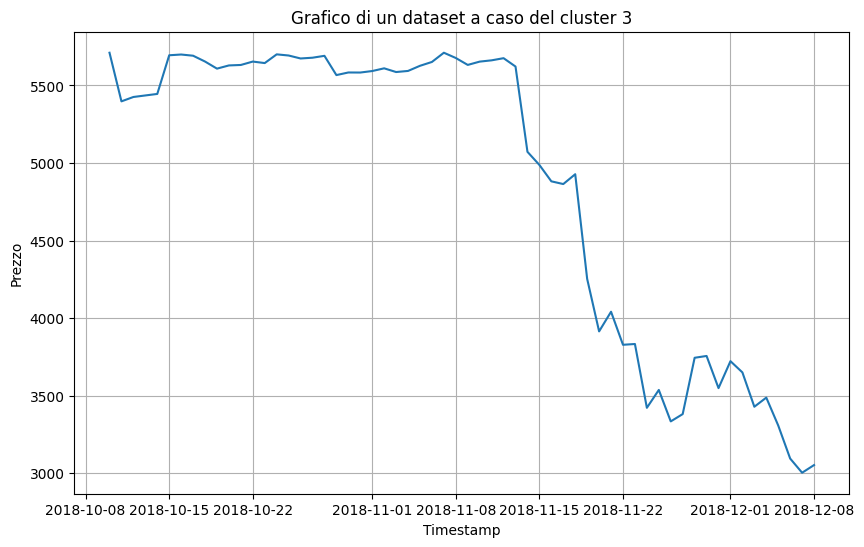

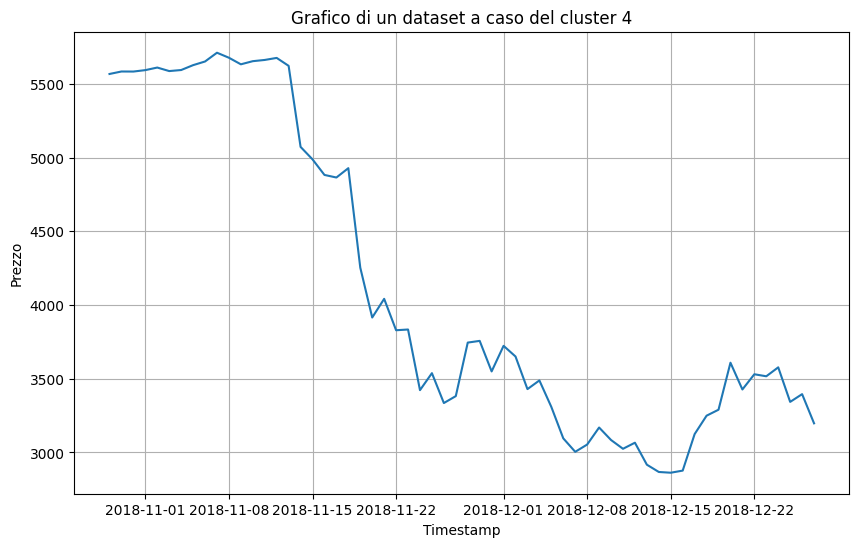

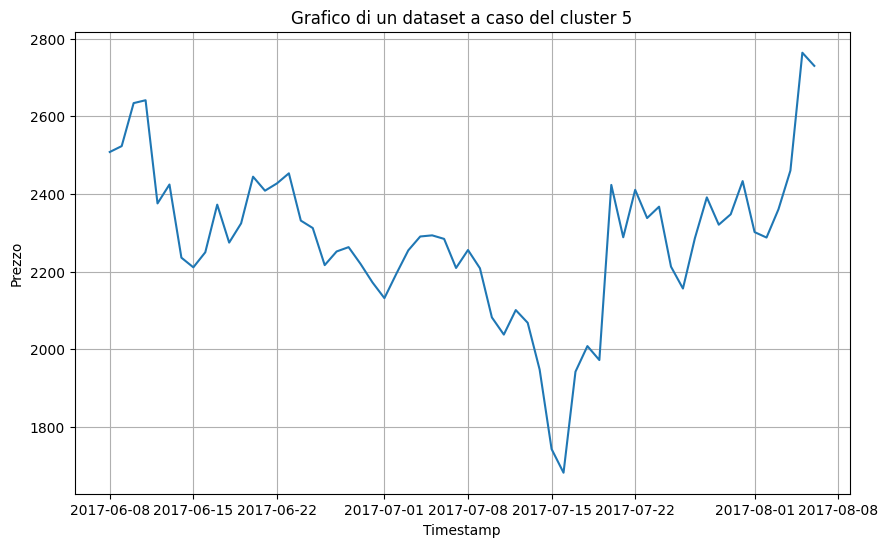

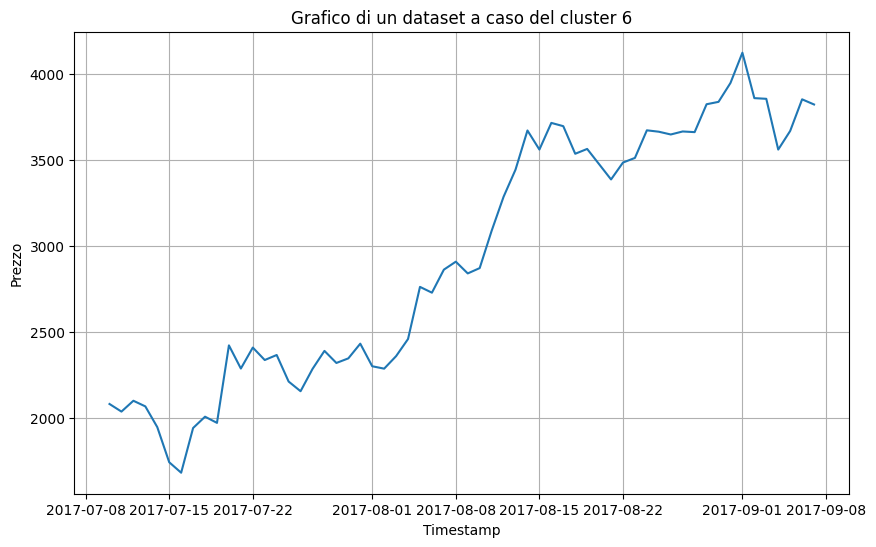

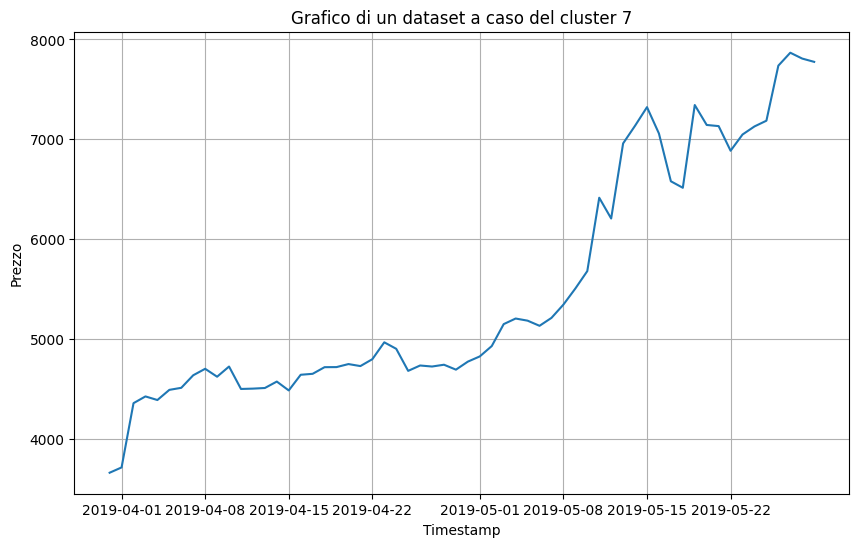

In [14]:
# Stampa un grafico di un dataset a caso per ogni cluster
import random
for i, stat in enumerate(statistiche):
    if stat['Numero di dataset'] > 0:
        cluster_i = [df for df, cluster in zip(dati_da_usare, clusters) if cluster == i]
        dataset_a_caso = random.choice(cluster_i)
        plt.figure(figsize=(10, 6))
        plt.plot(dataset_a_caso['Timestamp'], dataset_a_caso['Price'])
        plt.title(f'Grafico di un dataset a caso del cluster {i+1}')
        plt.xlabel('Timestamp')
        plt.ylabel('Prezzo')
        plt.grid()
        plt.show()

## Generazione dataset sintetici per riempire da 0 tutti i cluster con i punteggi desiderati

In [15]:
def calcola_distribuzione_variazioni(dati, n_bins):
    # Calcola le variazioni giornaliere del dataset originale
    variazioni = dati['Price'].pct_change().dropna().reset_index(drop=True)
    distribuzione_variazioni = {}
    bins = np.linspace(np.min(variazioni), np.max(variazioni), n_bins + 1)
    
    for i in range(n_bins):
        bin_min = bins[i]
        bin_max = bins[i + 1]
        if i < n_bins - 1:
            variazioni_bin = variazioni[(variazioni >= bin_min) & (variazioni < bin_max)]
        else:
            variazioni_bin = variazioni[(variazioni >= bin_min) & (variazioni <= bin_max)]
        
        mean_value = np.mean(variazioni_bin)
        prob_value = len(variazioni_bin) / len(variazioni)
        
        # Aggiungo al dizionario solo se il valore medio non è NaN, cioè se c'è almeno 1 variazione in questo bin
        if not np.isnan(mean_value):
            distribuzione_variazioni[f"[{bin_min:.4f}, {bin_max:.4f}]"] = (mean_value, prob_value)
    
    return distribuzione_variazioni

In [16]:
def genera_dataset_sintetico(L, punteggio_target, distribuzione_variazioni_positive, distribuzione_variazioni_negative):
    # Genera un dataset sintetico di lunghezza L giorni con un punteggio di bullishness target
    prezzi = [100]  # Prezzo iniziale
    for _ in range(L - 1):
        if np.random.rand() < (punteggio_target + 1) / 2: # Converto il punteggio da [-1, 1] a [0, 1]
            # Aggiungi una salita
            variazioni = [valore[0] for valore in distribuzione_variazioni_positive.values()]
            probabilita = [valore[1] for valore in distribuzione_variazioni_positive.values()]
        else:
            # Aggiungi una discesa
            variazioni = [valore[0] for valore in distribuzione_variazioni_negative.values()]
            probabilita = [valore[1] for valore in distribuzione_variazioni_negative.values()]

        # Normalizzo le probabilità per assicurarmi che sommino a 1
        probabilita = probabilita / np.sum(probabilita)

        variazione = np.random.choice(variazioni, p=probabilita)
        prezzi.append(prezzi[-1] * (1 + variazione))
    return prezzi

In [28]:
# Parametri
n_clusters = 7
dataset_per_cluster = 100
L = 60  # lunghezza dei dataset in giorni
n_bins = 50


# Suddividi l'intervallo (-1, 1) in n_clusters intervalli più piccoli e delle stesse dimensioni
intervallo = np.linspace(-1, 1, n_clusters + 1)

distribuzione_variazioni = calcola_distribuzione_variazioni(dati, n_bins)
distribuzione_variazioni_positive = {chiave: valore for chiave, valore in distribuzione_variazioni.items() if valore[0] > 0}
distribuzione_variazioni_negative = {chiave: valore for chiave, valore in distribuzione_variazioni.items() if valore[0] < 0}

# Genera dei dataset sintetici per ogni cluster
dataset_sintetici = []
for i in range(n_clusters):
    # Calcola il range di punteggi per il cluster i
    min_punteggio = intervallo[i]
    max_punteggio = intervallo[i + 1]

    # Genera dei dataset sintetici per il cluster i
    for j in range(dataset_per_cluster):
        # Genera un dataset casuale di lunghezza L giorni
        punteggio_target = np.random.uniform(min_punteggio, max_punteggio)
        dataset = pd.DataFrame({
            'Timestamp': pd.date_range(start='2000-01-01', periods=L),
            'Price': genera_dataset_sintetico(L, punteggio_target, distribuzione_variazioni_positive, distribuzione_variazioni_negative)
        })

        # Calcola il punteggio del dataset
        differenze = np.diff(dataset['Price'])
        salite = np.sum(differenze[differenze > 0])
        discese = np.sum(np.abs(differenze[differenze < 0]))
        punteggio = 2 * (salite / (salite + discese)) - 1

        # Se il punteggio non è nel range del cluster i, rigenero il dataset (la condizione if np.random.rand() < (punteggio_target + 1) / 2 tende a favorire il punteggio desiderato, ma non è detto in generale che poi il punteggio sia quello)
        while punteggio < min_punteggio or punteggio > max_punteggio:
            print(f'Sono entrato nel while per il cluster {i+1} e dataset numero {j+1}')
            dataset = pd.DataFrame({
                'Timestamp': pd.date_range(start='2000-01-01', periods=L),
                'Price': genera_dataset_sintetico(L, punteggio_target, distribuzione_variazioni_positive, distribuzione_variazioni_negative)
            })
            differenze = np.diff(dataset['Price'])
            salite = np.sum(differenze[differenze > 0])
            discese = np.sum(np.abs(differenze[differenze < 0]))
            punteggio = 2 * (salite / (salite + discese)) - 1

        # Aggiungi il dataset sintetico alla lista
        dataset_sintetici.append({'Cluster': i+1, 'Dataset': dataset, 'Punteggio': punteggio_target})

# Visualizza i dataset sintetici
# for i, dataset in enumerate(dataset_sintetici):
#     print(f"Dataset {i+1}:")
#     display(dataset.head())
#     print()

Sono entrato nel while per il cluster 1 e dataset numero 10
Sono entrato nel while per il cluster 1 e dataset numero 11
Sono entrato nel while per il cluster 1 e dataset numero 45
Sono entrato nel while per il cluster 1 e dataset numero 51
Sono entrato nel while per il cluster 1 e dataset numero 79
Sono entrato nel while per il cluster 1 e dataset numero 98
Sono entrato nel while per il cluster 1 e dataset numero 98
Sono entrato nel while per il cluster 2 e dataset numero 1
Sono entrato nel while per il cluster 2 e dataset numero 1
Sono entrato nel while per il cluster 2 e dataset numero 1
Sono entrato nel while per il cluster 2 e dataset numero 1
Sono entrato nel while per il cluster 2 e dataset numero 1
Sono entrato nel while per il cluster 2 e dataset numero 3
Sono entrato nel while per il cluster 2 e dataset numero 3
Sono entrato nel while per il cluster 2 e dataset numero 3
Sono entrato nel while per il cluster 2 e dataset numero 3
Sono entrato nel while per il cluster 2 e dataset

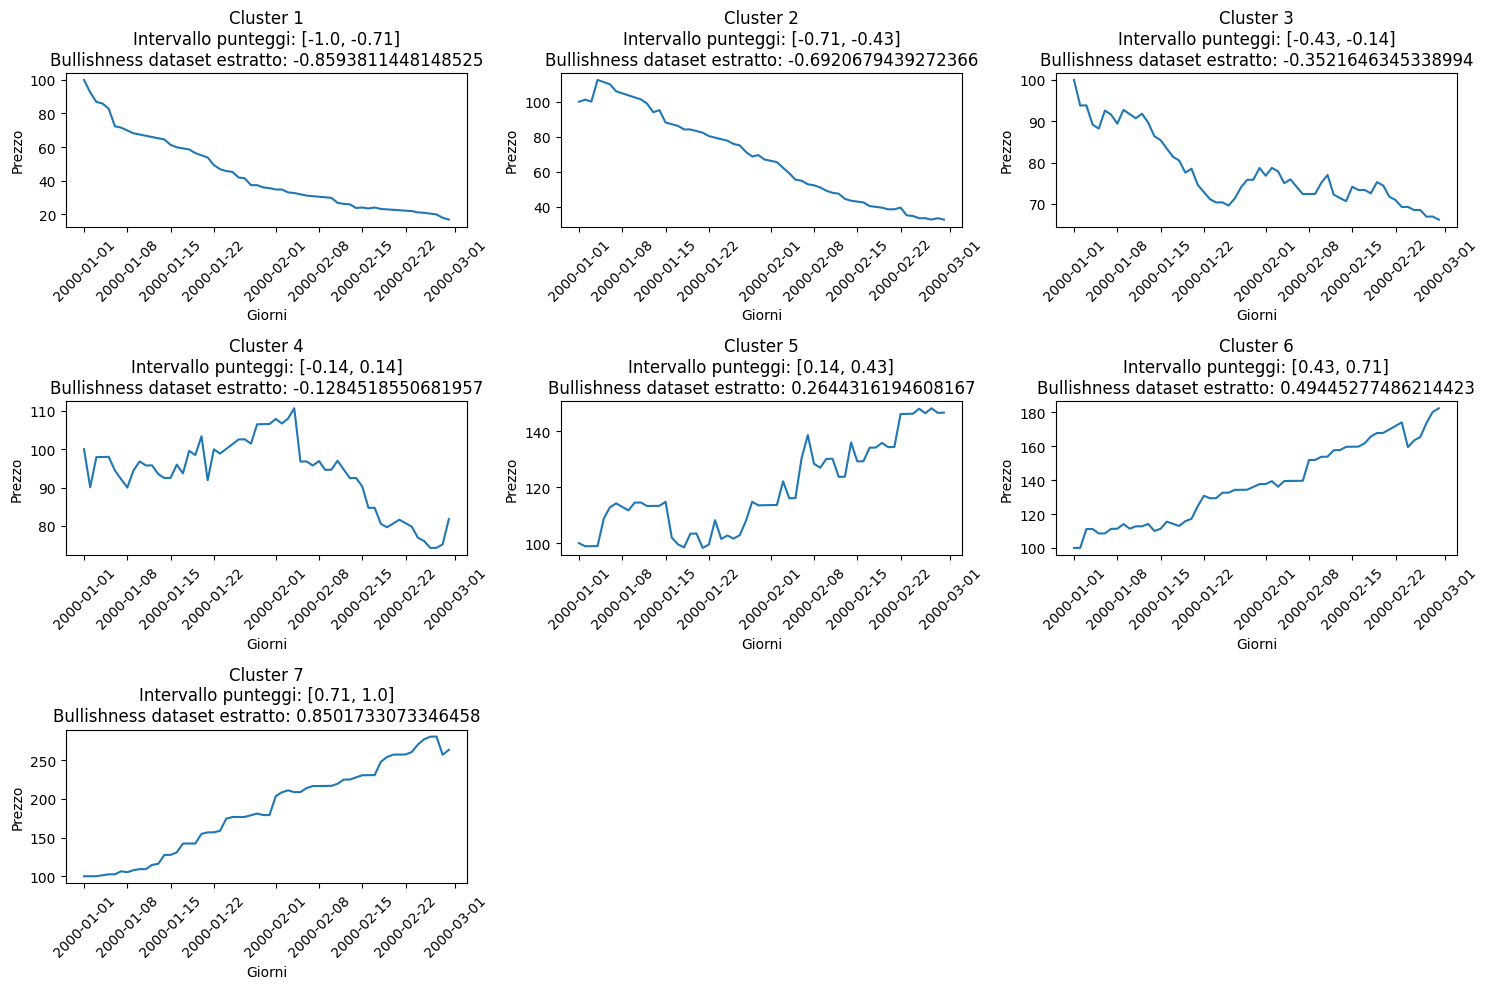

In [29]:
# Seleziona un dataset casuale per ogni cluster e crea un grafico
def plot_dataset_per_cluster(dataset_sintetici, n_clusters, distribuzione_variazioni):
    plt.figure(figsize=(15, 10))

    for i in range(n_clusters):
        # Filtra i dataset del cluster corrente
        datasets_cluster = [d for d in dataset_sintetici if d['Cluster'] == i + 1]
        
        # Seleziona un dataset casuale
        dizionario_casuale = random.choice(datasets_cluster)
        dataset_casuale = dizionario_casuale['Dataset']
        punteggio_dataset_casuale = dizionario_casuale['Punteggio']
        
        # Crea il subplot per il cluster
        plt.subplot(3, 3, i + 1)  # 3 righe, 3 colonne di grafici
        plt.plot(dataset_casuale['Timestamp'], dataset_casuale['Price'], label=f'Cluster {i + 1}')
        plt.xlabel('Giorni')
        plt.ylabel('Prezzo')
        plt.title(f'Cluster {i + 1}\nIntervallo punteggi: {[round(-1 + i * 2 / n_clusters, 2), round(-1 + (i + 1) * 2 / n_clusters, 2)]}\nBullishness dataset estratto: {punteggio_dataset_casuale}')
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Chiama la funzione per visualizzare i grafici
plot_dataset_per_cluster(dataset_sintetici, n_clusters, distribuzione_variazioni)

### Salvo i csv dei dataset presenti in ogni cluster in una cartella

In [31]:
# # Crea la cartella se non esiste
# directory = "7 cluster con 100 dataset sintetici"
# if not os.path.exists(directory):
#     os.makedirs(directory)

# # Funzione per salvare i dataset sintetici in CSV
# def salva_dataset_per_cluster(dataset_sintetici, n_clusters):
#     for i in range(n_clusters):
#         # Filtra i dataset del cluster corrente
#         datasets_cluster = [d['Dataset'] for d in dataset_sintetici if d['Cluster'] == i + 1]
        
#         # Crea un DataFrame per ogni cluster
#         df_cluster = pd.DataFrame()
#         df_cluster['Timestamp'] = datasets_cluster[0]['Timestamp']  # Uso il Timestamp dal primo dataset
        
#         # Aggiungi le colonne con i prezzi generati
#         for j, dataset in enumerate(datasets_cluster[:dataset_per_cluster]):
#             df_cluster[f'Generated_Price_{j + 1}'] = dataset['Price']
        
#         # Salva il DataFrame come CSV nella cartella
#         csv_path = os.path.join(directory, f'Cluster_{i + 1}.csv')
#         df_cluster.to_csv(csv_path, index=False)
#         print(f'Salvato {csv_path}')

# # Chiama la funzione per salvare i dataset sintetici
# salva_dataset_per_cluster(dataset_sintetici, n_clusters)

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_465200\901169699.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cluster[f'Generated_Price_{j + 1}'] = dataset['Price']


Salvato 7 cluster con 100 dataset sintetici\Cluster_1.csv
Salvato 7 cluster con 100 dataset sintetici\Cluster_2.csv


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_465200\901169699.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cluster[f'Generated_Price_{j + 1}'] = dataset['Price']
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_465200\901169699.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cluster[f'Generated_Price_{j + 1}'] = dataset['Price']


Salvato 7 cluster con 100 dataset sintetici\Cluster_3.csv


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_465200\901169699.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cluster[f'Generated_Price_{j + 1}'] = dataset['Price']


Salvato 7 cluster con 100 dataset sintetici\Cluster_4.csv


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_465200\901169699.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cluster[f'Generated_Price_{j + 1}'] = dataset['Price']


Salvato 7 cluster con 100 dataset sintetici\Cluster_5.csv


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_465200\901169699.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cluster[f'Generated_Price_{j + 1}'] = dataset['Price']
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_465200\901169699.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cluster[f'Generated_Price_{j + 1}'] = dataset['Price']


Salvato 7 cluster con 100 dataset sintetici\Cluster_6.csv
Salvato 7 cluster con 100 dataset sintetici\Cluster_7.csv
